# ECG Masking Strategy Visualization (All 12 Leads)

This notebook visualizes masking strategies on **all 12 leads** of an ECG:
- Each ECG is divided into **200 patches** (25 samples each, applied to all leads simultaneously)
- Masking happens on patches (same mask for all leads)

**Strategies:**
1. **ECG-JEPA (Mask-and-Complement)**: Masks 75-85% of patches.
2. **I-JEPA (Context-to-Target)**: ONE contiguous context block (85-95%), 4 target blocks (15-20% each).

In [1]:
import sys
import os
from pathlib import Path
import importlib

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, os.getcwd())

import data.masks
importlib.reload(data.masks)
from data.masks import MaskCollator, IJEPAMaskCollator

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.grid'] = False

print("Masks module reloaded!")

Masks module reloaded!


In [2]:
# Configuration
DATA_PATH = Path("../../ecg/data/ptb-xl.npy")
PATCH_SIZE = 25
NUM_PATCHES = 200
CROP_SIZE = PATCH_SIZE * NUM_PATCHES
CHANNELS = 12
SAMPLING_FREQUENCY = 500

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def load_single_ecg(path: Path):
    if path.is_file():
        arr = np.load(path, mmap_mode='r')
        idx = np.random.randint(0, len(arr))
        sample = np.array(arr[idx])
        ecg = sample if sample.shape[0] == CHANNELS else sample.T
        if ecg.shape[1] < CROP_SIZE:
            pad = np.zeros((CHANNELS, CROP_SIZE), dtype=ecg.dtype)
            pad[:, :ecg.shape[1]] = ecg
            ecg = pad
        elif ecg.shape[1] > CROP_SIZE:
            start = np.random.randint(0, ecg.shape[1] - CROP_SIZE + 1)
            ecg = ecg[:, start:start + CROP_SIZE]
        print(f"Loaded ECG #{idx} from {path}")
        return torch.from_numpy(ecg).float()
    else:
        print(f"File not found. Using synthetic signal.")
        return torch.randn(CHANNELS, CROP_SIZE)

ecg = load_single_ecg(DATA_PATH)
print(f"ECG shape: {ecg.shape} (12 leads x 5000 samples)")

Loaded ECG #17111 from ../../ecg/data/ptb-xl.npy
ECG shape: torch.Size([12, 5000]) (12 leads x 5000 samples)


In [3]:
# Create collators
original_collator = MaskCollator(
    patch_size=PATCH_SIZE, 
    min_block_size=10, 
    min_keep_ratio=0.15, 
    max_keep_ratio=0.25
)

ijepa_collator = IJEPAMaskCollator(
    patch_size=PATCH_SIZE,
    context_scale=(0.85, 0.95),
    pred_scale=(0.15, 0.20),
    num_pred_blocks=4,
    min_keep=10
)

# Get masks (batch of 1)
_, orig_context, orig_targets = original_collator([ecg])
_, ijepa_context_list, ijepa_targets_list = ijepa_collator([ecg])

print("ECG-JEPA masks:")
print(f"  Context: {orig_context.shape[1]} patches ({orig_context.shape[1]/NUM_PATCHES*100:.0f}%)")
print(f"  Targets: {orig_targets.shape[1]} patches ({orig_targets.shape[1]/NUM_PATCHES*100:.0f}%)")

print("\nI-JEPA masks:")
print(f"  Context: {ijepa_context_list[0].shape[1]} patches")
for i, t in enumerate(ijepa_targets_list):
    print(f"  Target {i+1}: {t.shape[1]} patches")

ECG-JEPA masks:
  Context: 48 patches (24%)
  Targets: 152 patches (76%)

I-JEPA masks:
  Context: 95 patches
  Target 1: 33 patches
  Target 2: 33 patches
  Target 3: 36 patches
  Target 4: 34 patches


## Full 12-Lead Visualization Function

In [4]:
def plot_12_lead_masked(ecg, context_patches, target_patches_list, title):
    """Plot all 12 leads of an ECG with masking visualization."""
    
    time_axis = np.arange(ecg.shape[1]) / SAMPLING_FREQUENCY
    seconds_per_patch = PATCH_SIZE / SAMPLING_FREQUENCY
    total_duration = ecg.shape[1] / SAMPLING_FREQUENCY
    
    context_set = set(context_patches)
    all_target_set = set()
    for block in target_patches_list:
        all_target_set.update(block)
    
    # Stats
    ctx_pct = len(context_set) / NUM_PATCHES * 100
    tgt_pct = len(all_target_set) / NUM_PATCHES * 100
    ignored = NUM_PATCHES - len(context_set) - len(all_target_set - context_set)
    
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    print(f"Context: {len(context_set)} patches ({ctx_pct:.1f}%)")
    print(f"Targets: {len(all_target_set)} unique patches ({tgt_pct:.1f}%)")
    print(f"Ignored: {ignored} patches ({ignored/NUM_PATCHES*100:.1f}%)")
    for i, block in enumerate(target_patches_list):
        block_sorted = sorted(set(block))
        if block_sorted:
            print(f"  Target {i+1}: patches {block_sorted[0]}-{block_sorted[-1]} ({len(block_sorted)} patches)")
    
    # Colors
    color_context = '#2E86AB'  # Blue
    color_ignored = '#E8E8E8'  # Light gray
    target_colors = ['#E94F37', '#F39C12', '#27AE60', '#9B59B6']  # Red, Orange, Green, Purple
    
    # Create figure: 12 leads + 1 patch bar at top
    fig, axes = plt.subplots(13, 1, figsize=(18, 16), 
                              height_ratios=[0.8] + [1]*12,
                              sharex=True, dpi=100)
    
    ax_patches = axes[0]
    lead_axes = axes[1:]
    
    # --- Top: Patch visualization bar ---
    for p in range(NUM_PATCHES):
        x0 = p * seconds_per_patch
        x1 = (p + 1) * seconds_per_patch
        
        in_target = None
        for i, block in enumerate(target_patches_list):
            if p in block:
                in_target = i
                break
        
        if in_target is not None:
            color = target_colors[in_target % len(target_colors)]
            alpha = 0.85
        elif p in context_set:
            color = color_context
            alpha = 0.7
        else:
            color = color_ignored
            alpha = 0.5
        
        ax_patches.axvspan(x0, x1, color=color, alpha=alpha, lw=0)
    
    ax_patches.set_xlim(0, total_duration)
    ax_patches.set_ylim(0, 1)
    ax_patches.set_yticks([])
    ax_patches.set_title(title, fontsize=14, fontweight='bold', loc='left', pad=10)
    
    # Patch markers every 50 patches
    for p in range(0, NUM_PATCHES + 1, 50):
        x = p * seconds_per_patch
        ax_patches.axvline(x, color='black', lw=0.8, alpha=0.6)
        ax_patches.text(x, 1.15, str(p), ha='center', fontsize=9, 
                        transform=ax_patches.get_xaxis_transform())
    
    # --- 12 Lead signals ---
    for lead_idx, ax in enumerate(lead_axes):
        signal = ecg[lead_idx].numpy()
        
        for p in range(NUM_PATCHES):
            start_sample = p * PATCH_SIZE
            end_sample = (p + 1) * PATCH_SIZE
            patch_time = time_axis[start_sample:end_sample]
            patch_signal = signal[start_sample:end_sample]
            
            in_target = None
            for i, block in enumerate(target_patches_list):
                if p in block:
                    in_target = i
                    break
            
            if in_target is not None:
                color = target_colors[in_target % len(target_colors)]
                lw = 1.0
            elif p in context_set:
                color = color_context
                lw = 0.9
            else:
                color = '#CCCCCC'
                lw = 0.6
            
            ax.plot(patch_time, patch_signal, color=color, linewidth=lw)
        
        ax.set_ylabel(LEAD_NAMES[lead_idx], fontsize=10, rotation=0, ha='right', va='center')
        ax.set_xlim(0, total_duration)
        ax.tick_params(axis='y', labelsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, axis='x', alpha=0.2, linestyle='-')
    
    lead_axes[-1].set_xlabel('Time (seconds)', fontsize=11)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=color_context, alpha=0.7, label='Context (visible to encoder)'),
        mpatches.Patch(facecolor=color_ignored, alpha=0.5, label='Ignored'),
    ]
    for i in range(len(target_patches_list)):
        legend_elements.append(
            mpatches.Patch(facecolor=target_colors[i % len(target_colors)], 
                          alpha=0.85, label=f'Target {i+1} (to predict)')
        )
    
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99),
               frameon=True, framealpha=0.95, fontsize=10, ncol=2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.15)
    plt.show()

## ECG-JEPA: Mask-and-Complement Strategy

- **Context**: 15-25% of patches (scattered)
- **Targets**: 75-85% of patches (everything else)
- Model predicts ALL masked patches from the small context


ECG-JEPA: Mask-and-Complement
Context: 48 patches (24.0%)
Targets: 152 unique patches (76.0%)
Ignored: 0 patches (0.0%)
  Target 1: patches 9-176 (152 patches)


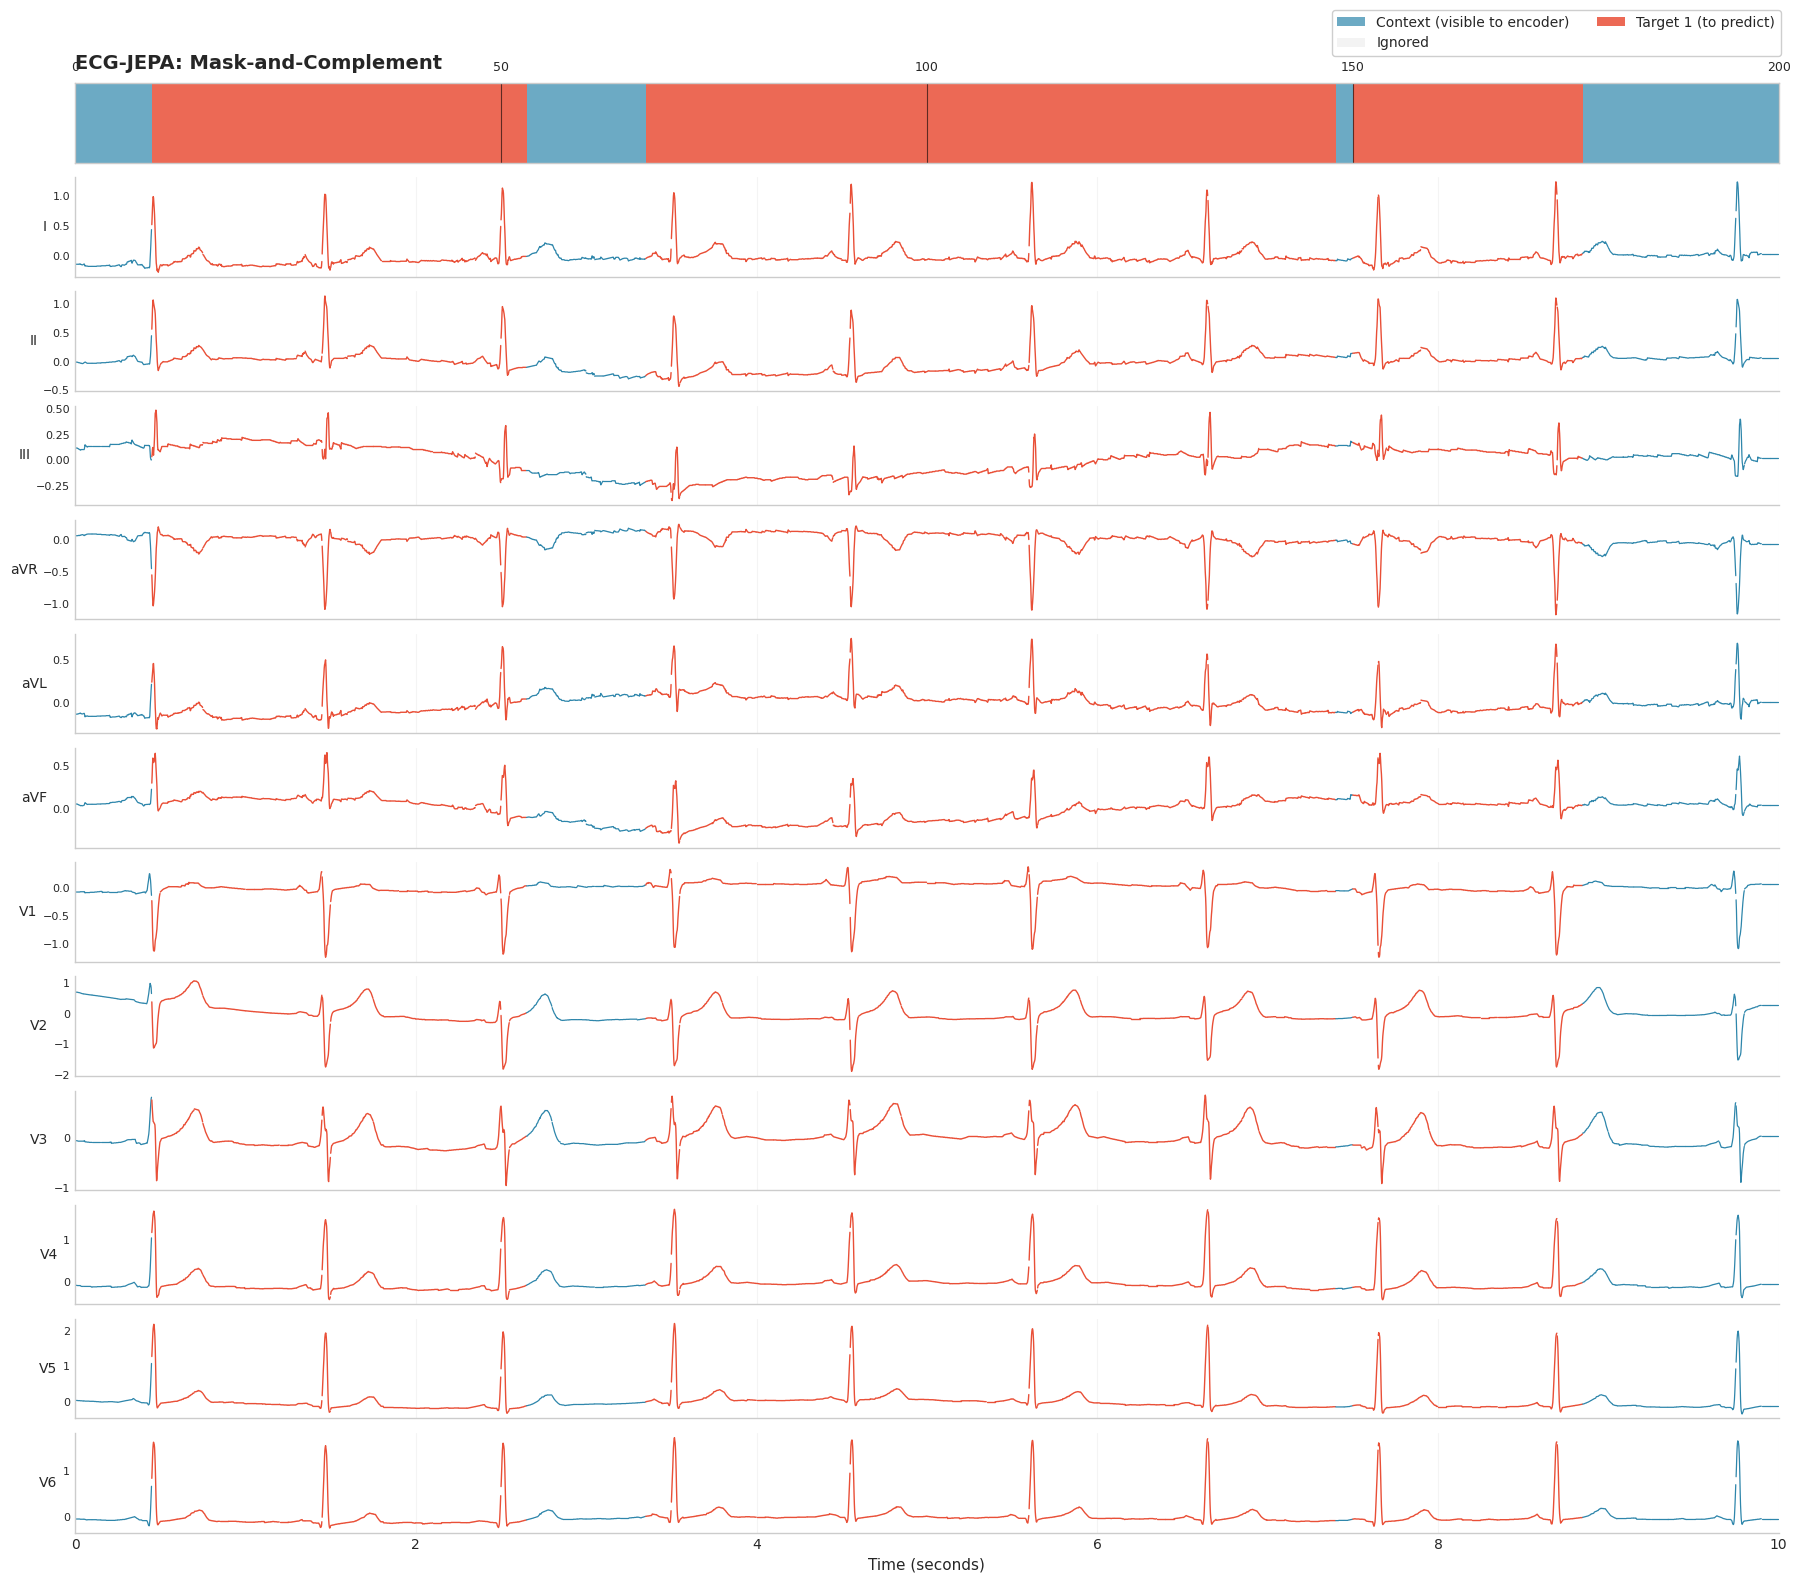

In [5]:
# ECG-JEPA visualization
ctx = orig_context[0].numpy().tolist()
tgt = orig_targets[0].numpy().tolist()

plot_12_lead_masked(ecg, ctx, [tgt], "ECG-JEPA: Mask-and-Complement")

## I-JEPA: Context-to-Target Strategy

- **Context**: One large contiguous block (85-95%), then remove overlap with targets
- **Targets**: 4 separate blocks (15-20% each), may overlap with each other
- Model predicts specific target blocks from the large context


I-JEPA: Context-to-Target (4 Target Blocks)
Context: 95 patches (47.5%)
Targets: 75 unique patches (37.5%)
Ignored: 30 patches (15.0%)
  Target 1: patches 13-45 (33 patches)
  Target 2: patches 48-80 (33 patches)
  Target 3: patches 15-50 (36 patches)
  Target 4: patches 54-87 (34 patches)


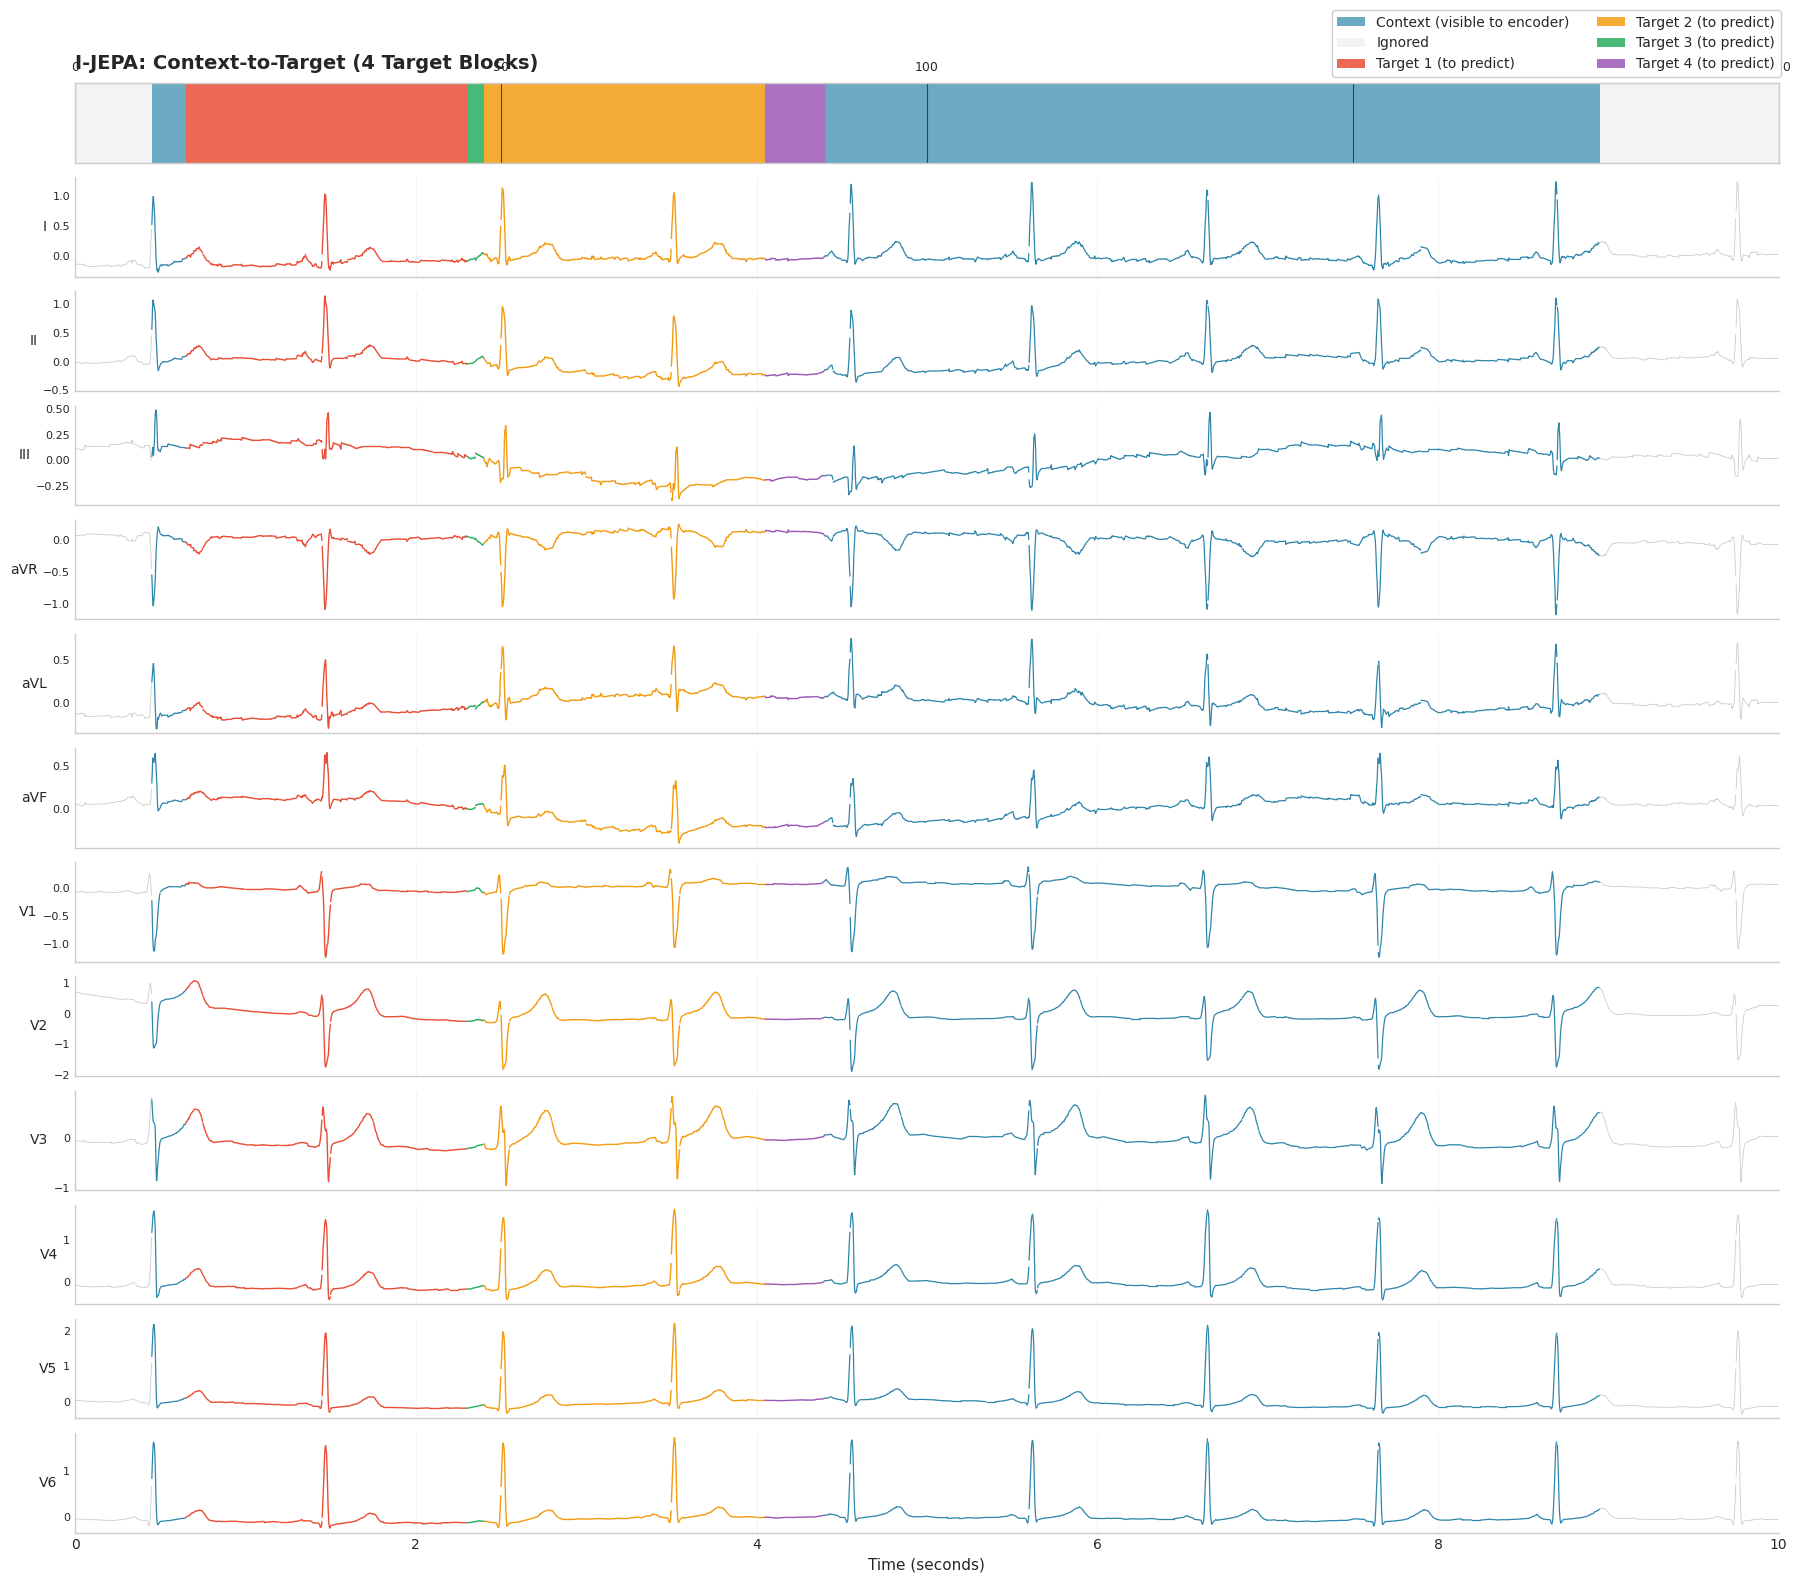

In [6]:
# I-JEPA visualization
ctx = list(set(ijepa_context_list[0][0].numpy().tolist()))

target_blocks = []
for t in ijepa_targets_list:
    block = list(set(t[0].numpy().tolist()))
    target_blocks.append(block)

plot_12_lead_masked(ecg, ctx, target_blocks, "I-JEPA: Context-to-Target (4 Target Blocks)")

## Side-by-Side Comparison (Single Lead)

Quick comparison of both strategies on Lead II

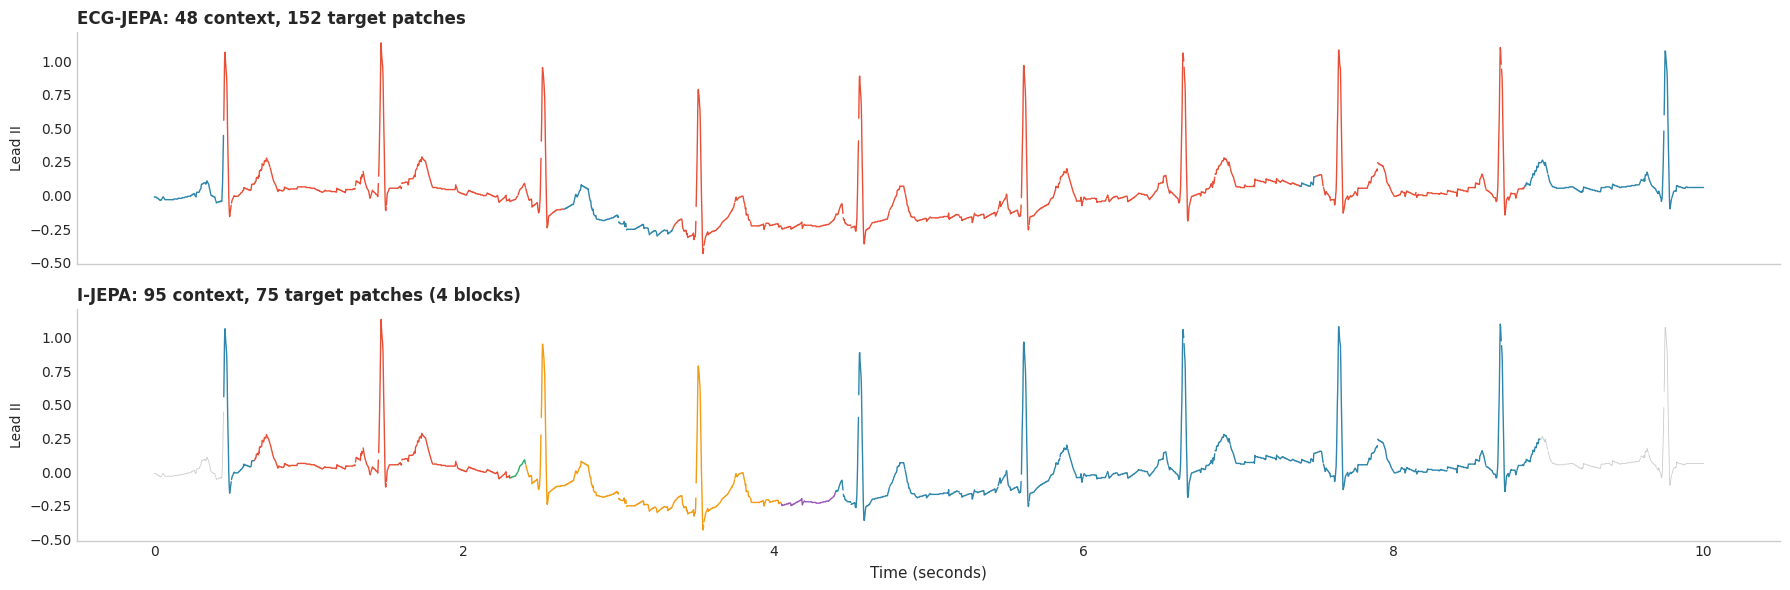

In [7]:
def plot_comparison(ecg, ecgjepa_ctx, ecgjepa_tgt, ijepa_ctx, ijepa_targets, lead=1):
    """Side-by-side comparison of both strategies on a single lead."""
    
    time_axis = np.arange(ecg.shape[1]) / SAMPLING_FREQUENCY
    signal = ecg[lead].numpy()
    
    color_context = '#2E86AB'
    target_colors = ['#E94F37', '#F39C12', '#27AE60', '#9B59B6']
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True, dpi=100)
    
    # ECG-JEPA
    ax = axes[0]
    ctx_set = set(ecgjepa_ctx)
    tgt_set = set(ecgjepa_tgt)
    
    for p in range(NUM_PATCHES):
        start = p * PATCH_SIZE
        end = (p + 1) * PATCH_SIZE
        t = time_axis[start:end]
        s = signal[start:end]
        
        if p in tgt_set:
            ax.plot(t, s, color=target_colors[0], lw=1.0)
        else:
            ax.plot(t, s, color=color_context, lw=1.0)
    
    ax.set_title(f'ECG-JEPA: {len(ctx_set)} context, {len(tgt_set)} target patches', 
                 fontsize=12, fontweight='bold', loc='left')
    ax.set_ylabel(f'Lead {LEAD_NAMES[lead]}', fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # I-JEPA
    ax = axes[1]
    ctx_set = set(ijepa_ctx)
    all_tgt = set()
    for b in ijepa_targets:
        all_tgt.update(b)
    
    for p in range(NUM_PATCHES):
        start = p * PATCH_SIZE
        end = (p + 1) * PATCH_SIZE
        t = time_axis[start:end]
        s = signal[start:end]
        
        in_target = None
        for i, block in enumerate(ijepa_targets):
            if p in block:
                in_target = i
                break
        
        if in_target is not None:
            ax.plot(t, s, color=target_colors[in_target], lw=1.0)
        elif p in ctx_set:
            ax.plot(t, s, color=color_context, lw=1.0)
        else:
            ax.plot(t, s, color='#CCCCCC', lw=0.6)
    
    ax.set_title(f'I-JEPA: {len(ctx_set)} context, {len(all_tgt)} target patches (4 blocks)', 
                 fontsize=12, fontweight='bold', loc='left')
    ax.set_ylabel(f'Lead {LEAD_NAMES[lead]}', fontsize=10)
    ax.set_xlabel('Time (seconds)', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Run comparison
ecgjepa_ctx = orig_context[0].numpy().tolist()
ecgjepa_tgt = orig_targets[0].numpy().tolist()
ijepa_ctx = list(set(ijepa_context_list[0][0].numpy().tolist()))
ijepa_tgts = [list(set(t[0].numpy().tolist())) for t in ijepa_targets_list]

plot_comparison(ecg, ecgjepa_ctx, ecgjepa_tgt, ijepa_ctx, ijepa_tgts, lead=1)

## Key Insight: Same Mask for All Leads

Notice that **all 12 leads share the same mask**. This is because:
1. Each patch contains ALL 12 leads at that time window
2. The encoder processes patches as `[batch, num_patches, dim]` where `dim` encodes all leads
3. Masking removes entire time windows across all leads simultaneously

This is different from masking individual leads independently.